### Import library

In [1]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from PIL import Image
from IPython.display import display, clear_output

### Define functions

In [2]:
def rectify(h):
    h = h.reshape((4, 2))
    hnew = np.zeros((4, 2), dtype=np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h, axis=1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew


def resize_image(image, width, height):
    image = cv2.resize(image, (width, height))
    return image


def gray_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image


def canny_edge_detection(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    edges = auto_canny(blurred_image)
    return edges


def find_contours(image):
    (contours, _) = cv2.findContours(image, cv2.RETR_LIST,
                                     cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for c in contours:
        p = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * p, True)

        if len(approx) == 4:
            target = approx
            break
    return target


def draw_contours(orig_image, image, target):
    approx = rectify(target)
    pts2 = np.float32([[0, 0], [800, 0], [800, 800], [0, 800]])

    M = cv2.getPerspectiveTransform(approx, pts2)
    result = cv2.warpPerspective(image, M, (800, 800))

    cv2.drawContours(image, [target], -1, (0, 255, 0), 2)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    return result


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


def cv2_show(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(image))

### Load the image, 

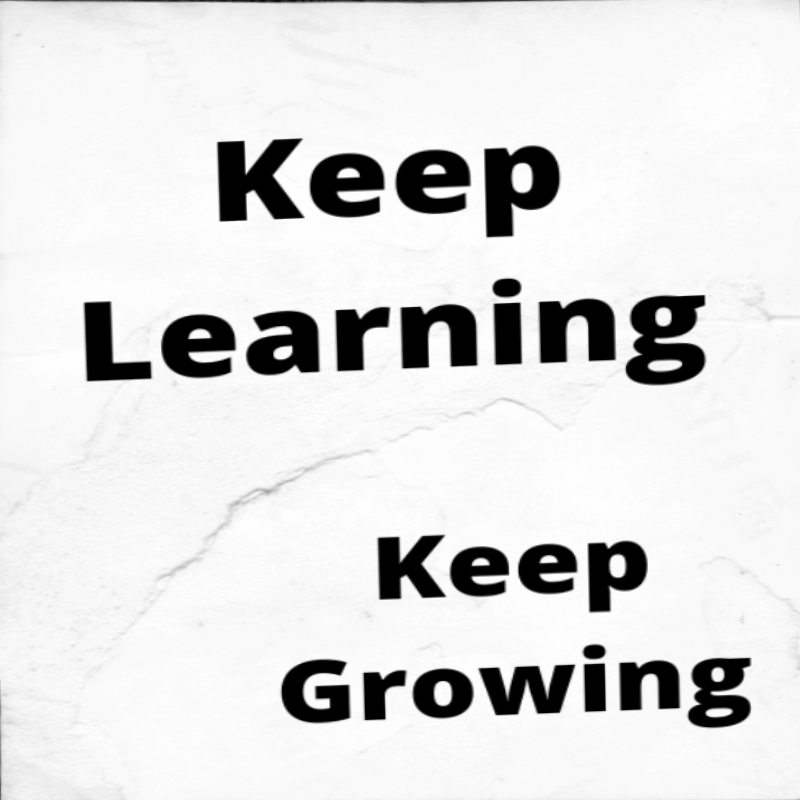

In [3]:
image = cv2.imread('learn.png')
image = resize_image(image,1500,800)
orig = image.copy()
gray = gray_image(image)
edges = canny_edge_detection(gray)
target = find_contours(edges)
output = draw_contours(orig, image, target)
cv2_show(output)

### OCR predict and print all found strings

In [4]:
raw_string = pytesseract.image_to_string(output)
print(raw_string)

Keep
Learning

Keep
Growing



### Draw rectangle and text on the word

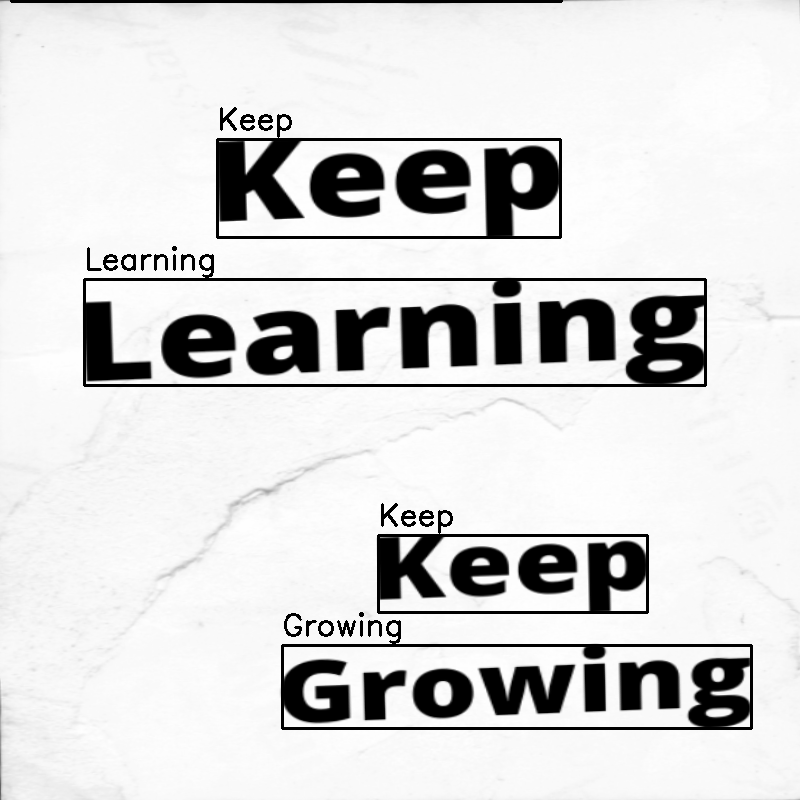

In [5]:
d = pytesseract.image_to_data(output, output_type=Output.DICT)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(output, d['text'][i], (x, y- 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

cv2_show(output)